In [1]:
import mne

from crosspy.core.methods import cplv, cplv_pairwise
from crosspy.preprocessing.seeg.support import clean_montage, drop_monopolar_channels
from crosspy.preprocessing.seeg.seeg_utils import create_reference_mask, get_electrode_distance
from crosspy.preprocessing.signal import preprocess_data_morlet

import os

import numpy as np
import glob

import matplotlib.pyplot as plt

import scipy as sp
import scipy.cluster

import sklearn
from sklearn import metrics

import re
import pandas as pd

import pickle

import tqdm

from bids import BIDSLayout

from collections import defaultdict

from statsmodels.stats.multitest import multipletests

import seaborn as sns

import json

In [2]:
from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.166, 0.43, 0.43),
                   (0.33, 0.7, 0.7),
                   (0.5, 1.0, 1.0),
                   (0.66, 0.8, 0.8),
                   (1.0, 0.6, 0.6)),

         'green': ((0.0, 0.4, 0.4),
                   (0.166, 0.7, 0.7),
                   (0.33, 0.8, 0.8),
                   (0.5, 1.0, 1.0),
                   (0.66, 0.8, 0.8),
                   (1.0,0.0, 0.0)),

         'blue':  ((0.0, 0.8, 0.8),
                   (0.166, 1.0, 1.0),
                   (0.33, 1.0, 1.0),
                   (0.5, 0.4, 0.4),
                   (0.66, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }

ripples_cmap = LinearSegmentedColormap('ripplescmap', cdict1)
ripples_blue = ripples_cmap(0)
ripples_red = ripples_cmap(0.99)
ripples_orange = ripples_cmap(0.7)

colors = [ripples_cmap(0), ripples_cmap(0.33), ripples_cmap(0.66), ripples_cmap(0.99)]

In [3]:
def get_frequencies():
    return np.load('gabriele/frequencies.npy')

def get_spectrum(fname, ez_mask):
    res_dict = pickle.load(open(fname, 'rb'))
    data = res_dict['cplv_spectrum']
    mask = np.logical_and(res_dict['reference_mask'].astype(bool), ez_mask)

    plv_spectrum = np.abs(data[:, mask]).mean(axis=1)
    iplv_spectrum = np.abs(np.imag(data[:, mask])).mean(axis=1)
    
    return plv_spectrum, iplv_spectrum

def get_spectrum_by_bins(data, ez_mask, distance_matrix):
    ref_mask = data['reference_mask'].astype(bool)
    spectrum = data['cplv_spectrum']
    surrogate_spectrum = data['surrogate_spectrum']
    
    n_bins = len(distance_bins) - 1
    dists_binned = np.digitize(distance_matrix, bins=distance_bins) - 1
    
    plv_binned = np.zeros((n_bins, spectrum.shape[0]))
    iplv_binned = np.zeros((n_bins, spectrum.shape[0]))
    plv_k = np.zeros((n_bins, spectrum.shape[0]))
    iplv_k = np.zeros((n_bins, spectrum.shape[0]))
    
    for bin_idx in range(n_bins):
        bin_mask = (dists_binned == bin_idx)
        
        mask = np.triu(ref_mask & ez_mask & bin_mask, 1)

        plv_masked = np.abs(spectrum[:, mask])
        iplv_masked = np.abs(np.imag(spectrum[:, mask]))
            
        plv_surr_values = np.abs(surrogate_spectrum[:,mask]).mean(axis=1, keepdims=True)*3.52
        iplv_surr_values = np.abs(np.imag(surrogate_spectrum[:,mask])).std(axis=1, keepdims=True)*3.52
        
        plv_binned[bin_idx] = plv_masked.mean(axis=1)
        iplv_binned[bin_idx] = iplv_masked.mean(axis=1)
        
        plv_k[bin_idx] = np.mean(plv_masked >= plv_surr_values, axis=1)
        iplv_k[bin_idx] = np.mean(iplv_masked >= iplv_surr_values, axis=1)
    
    return plv_binned, iplv_binned, plv_k, iplv_k

def get_replacement_map(labels_x, labels_y, n_clusters):
    def _cluster_similarity(x_idx, y_idx):
        return 1 - sp.spatial.distance.jaccard(labels_x == x_idx,  labels_y == y_idx)

    sim_matrix = np.zeros((n_clusters, n_clusters))

    for i in range(n_clusters):
        for j in range(n_clusters):
            sim_matrix[i,j] = _cluster_similarity(i, j)
    
    return {source:target for source, target in zip(*sp.optimize.linear_sum_assignment(-1*sim_matrix))}

def label_independent_similarity(labels_x, labels_y, n_clusters):
    labels_normalizer = get_replacement_map(labels_x, labels_y, n_clusters)
    labels_x_normed = np.array([labels_normalizer[l] for l in labels_x])
    
    return np.mean(labels_x_normed == labels_y)



def create_ez_mask(ez_chans):
    res = np.zeros((ez_chans.shape[0], ez_chans.shape[0]), dtype=bool)
    for i in range(ez_chans.shape[0]):
        for j in range(ez_chans.shape[0]):
            res[i,j] = ez_chans[i] == 0 and ez_chans[j] == 0
    
    return res

def is_bipolar(x):
    a, c = x.split('-')
    
    return len(c) > 0

def estimate_single_coeff(spectrum, N_rounds=1000, bins_values=[0,1,2,3]):
    n_subjects = spectrum.shape[1]
    bins = np.array(sum([[v]*n_subjects for v in bins_values], []))
    return sp.stats.spearmanr(bins, spectrum.flatten())[0]


def make_bipolar(data_fname, montage_filename, lowpass_frequency, pure_bipolar=False):
    raw = mne.io.read_raw_edf(data_fname, preload=False, verbose=False)
    mne.rename_channels(raw.info, lambda name: re.sub(r'(POL|SEEG)\s+', '', name).strip())

    channel_types = dict()

    for ch in raw.ch_names:
        result = re.match(r'^[A-Z][\']?\d+', ch)
        if result:
            channel_types[ch] = 'seeg'

    raw.set_channel_types(channel_types)

    if pure_bipolar:
        print('Print bipolar!')
        anode, cathode = get_bipolar_contacts(raw.ch_names)
    else:
        montage = pd.read_csv(montage_filename, delimiter='\t')
        montage.drop_duplicates(subset='name', inplace=True)

        anode,cathode = clean_montage(raw.ch_names, montage.anode.tolist(), montage.cathode.tolist())

    raw.load_data()

    bipo = mne.set_bipolar_reference(raw, list(anode), list(cathode), copy=True, verbose=False)
    bipo = drop_monopolar_channels(bipo)
    bipo.drop_channels(bipo.info['bads'])

    picks_seeg = mne.pick_types(bipo.info, meg=False, seeg=True)

    non_seeg_chans = [ch_name for ch_idx, ch_name in enumerate(bipo.ch_names) if not(ch_idx in picks_seeg) or len(ch_name.split('-')) == 1]
    bipo.drop_channels(non_seeg_chans)

    # bipo.notch_filter(np.arange(50, bipo.info['sfreq']//2, 50), n_jobs=32)
#     bipo.filter(None, lowpass_frequency, verbose=False, n_jobs=32)

    return bipo

def routine_cpu(bipo, sr, frequency, ez_mask):
    data = bipo.copy()

    hp_cut = frequency - 10
    lp_cut = frequency + 10 
    
    data.filter(hp_cut, lp_cut, l_trans_bandwidth=15, h_trans_bandwidth=15, n_jobs = 32, filter_length='1s')
    data.apply_hilbert(n_jobs=32) 

    data_preprocessed = data._data[:, ez_mask]
#     print(data_preprocessed.shape)

#     n_chans, n_ts = data_preprocessed.shape

#     surr_data = np.zeros_like(data_preprocessed)
#     for i in range(n_chans):
#         surr_data[i] = np.roll(data_preprocessed[i], np.random.randint(n_ts))

#     plv = np.inner(data_preprocessed, np.conj(data_preprocessed)) / n_ts
#     plv_surr = np.inner(surr_data, np.conj(surr_data)) / n_ts

    plv, plv_surr = cplv_pairwise(data_preprocessed, return_surr=True)
    
    return plv, plv_surr

In [4]:
df = pd.read_csv('../seeg_phases/data/SEEG_redux_BIDS/convert_results.csv')
df_num_idx = df.set_index('subject_number')

header=['subject', 'contact', 'EZ', 'GMPI']
ez_data = pd.read_csv('202001_SEEG_ripple_Cohort_Contacts.csv', sep=';', header=None)
ez_grouped = ez_data.groupby(0)

cluster_data = pd.read_csv('Subject_agg_cluster_labels.csv')
subject_to_cluster = cluster_data.set_index('subject_number')

In [5]:
frequencies = np.arange(25,500,50)
distance_bins = [0,  32,  45,  60, 137]

In [6]:
plv_spectrum = list()
iplv_spectrum = list()

surr_plv = list()
surr_iplv = list()

plv_k = list()
iplv_k = list()

spectrum_by_cluster = defaultdict(list)

subject_numbers = list()

root_path = os.path.join('../seeg_phases/data', 'SEEG_redux_BIDS')
layout = BIDSLayout(root_path)

for subject in tqdm.tqdm_notebook(layout.get(target='subject', extension='edf')): 
    subj_num = int(subject.entities['subject'])
    subj_name = df_num_idx.loc[subj_num]['name']
    subj_ez = ez_grouped.get_group(subj_name).set_index(1)
    
    if subj_num in {36}:
        continue

    subj_cluster = subject_to_cluster.loc[subj_num]['subject_cluster']
    
#     if subj_cluster == 4:
#         continue

    res_fname = 'derivatives/plv_spectrum_fir/sub-{}_spectrum.pickle'.format(subject.entities['subject'])
    montage_filename = os.path.join(subject.dirname,  'sub-{}_montage.tcsv'.format(subject.entities['subject']))
    electrodes_filename = os.path.join(subject.dirname,  'sub-{}_electrodes.tcsv'.format(subject.entities['subject']))
    
    res_data = pickle.load(open(res_fname, 'rb'))    
    ref_mask = res_data['reference_mask'].astype(bool)
    
    montage = pd.read_csv(montage_filename, sep='\t')
    montage = montage[montage['name'].apply(is_bipolar)]
    ch_names = montage['name'].values
    
    electrodes = pd.read_csv(electrodes_filename, sep='\t')
    distance_matrix = get_electrode_distance(ch_names, electrodes_filename)
        
    ez_chans = np.array([int(subj_ez.loc[ch][2] != 0) for ch in ch_names])
    ez_mask = create_ez_mask(ez_chans)
    
    subj_plv_whole = np.abs(res_data['cplv_spectrum'][:, ref_mask & ez_mask]).mean(axis=1)
    subj_plv, subj_iplv, subj_plv_k, subj_iplv_k = get_spectrum_by_bins(res_data, ez_mask, distance_matrix)

    spectrum_by_cluster[subj_cluster].append(subj_plv_whole)
        
    plv_spectrum.append(subj_plv)
    iplv_spectrum.append(subj_iplv)
    plv_k.append(subj_plv_k)
    iplv_k.append(subj_iplv_k)
    
    surr_plv.append(np.abs(res_data['surrogate_spectrum'][:, ref_mask & ez_mask]).mean(axis=1))
    surr_iplv.append(np.abs(np.imag(res_data['surrogate_spectrum'][:, ref_mask & ez_mask])).mean(axis=1))
    
    subject_numbers.append(subj_num)
    
plv_spectrum = np.array(plv_spectrum)
iplv_spectrum = np.array(iplv_spectrum)
plv_k = np.array(plv_k)
iplv_k = np.array(iplv_k)
surr_plv = np.array(surr_plv)
surr_iplv = np.array(surr_iplv)

In [7]:
plv_spectrums = np.concatenate(list(spectrum_by_cluster.values()))
outliers = set(plv_spectrums[:, 6].argsort()[-4:]) | \
            set(plv_spectrums[:, 7].argsort()[-2:]) | \
            set(plv_spectrums[:, 8].argsort()[-3:]) | \
            set(plv_spectrums[:, 9].argsort()[-2:])
outliers = list(outliers)
print(outliers)


mask = np.ones(plv_spectrum.shape[0], dtype=bool)
mask[outliers] = False

[65, 66, 36, 58, 24, 57, 26, 27, 28, 30, 31]


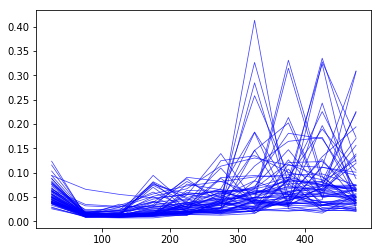

In [8]:
_ = plt.plot(frequencies, plv_spectrums.T, color='blue', lw=0.75, alpha=0.75)


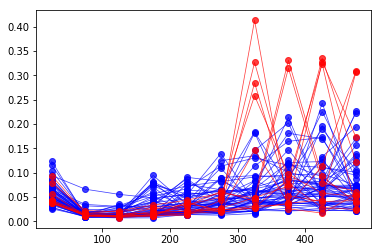

In [222]:
_ = plt.plot(frequencies, plv_spectrums[mask].T, marker='o', color='blue', lw=0.75, alpha=0.75)
_ = plt.plot(frequencies, plv_spectrums[~mask].T, marker='o', color='red', lw=0.75, alpha=0.75)

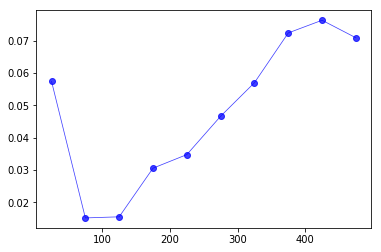

In [223]:
plt.plot(frequencies, plv_spectrums[mask].mean(axis=0), marker='o', color='blue', lw=0.75, alpha=0.75)

In [9]:
def estimate_surrogate(spectrum, N_rounds=1000, bins_values=[0,1,2,3]):
    n_subjects = spectrum.shape[1]
    bins = np.array(sum([[v]*n_subjects for v in bins_values], []))
    
    shuffled = spectrum.copy()
    res = np.zeros(N_rounds)
    for round_idx in range(N_rounds):
        _ = [np.random.shuffle(shuffled[:, sidx]) for sidx in range(n_subjects)]
        res[round_idx] = sp.stats.spearmanr(bins, shuffled.flatten())[0]
    
    return res
    
    
def estimate_bootstrapping(spectrum, N_rounds=1000, bins_values=[0,1,2,3]):
    n_subjects = spectrum.shape[1]
    idx = np.arange(spectrum.shape[0]*spectrum.shape[1])
        
    bins = np.array(sum([[v]*n_subjects for v in bins_values], []))
    shuffled = spectrum.flatten()
    
    res = np.zeros(N_rounds)
    for round_idx in range(N_rounds):
        round_indices = np.random.choice(idx, size=shuffled.shape[0])
        res[round_idx] = sp.stats.spearmanr(bins[round_indices], shuffled[round_indices])[0]
    
    return res

def estimate_mean_with_bootstrap(spectrum, N_rounds=1000):
    all_indices = np.arange(spectrum.shape[0])
        
    res = np.zeros((N_rounds, ) + spectrum.shape[1:])
    for idx in range(N_rounds):
        round_indices = np.random.choice(all_indices, size=all_indices.shape[0])
        res[idx] = spectrum[round_indices].mean(axis=0)
        
    return res

def estimate_median_with_bootstrap(spectrum, N_rounds=1000):
    all_indices = np.arange(spectrum.shape[0])
        
    res = np.zeros((N_rounds, ) + spectrum.shape[1:])
    for idx in range(N_rounds):
        round_indices = np.random.choice(all_indices, size=all_indices.shape[0])
        res[idx] = np.median(spectrum[round_indices], axis=0)
        
    return res

In [12]:
plv_bootstrapped = estimate_mean_with_bootstrap(plv_spectrum, N_rounds=10000)
iplv_bootstrapped = estimate_mean_with_bootstrap(iplv_spectrum, N_rounds=10000)
# plv_bootstrapped = estimate_median_with_bootstrap(plv_spectrum, N_rounds=10000)
# iplv_bootstrapped = estimate_median_with_bootstrap(iplv_spectrum, N_rounds=10000)

plv_k_bootstrapped = estimate_mean_with_bootstrap(plv_k, N_rounds=10000)
iplv_k_bootstrapped = estimate_mean_with_bootstrap(iplv_k, N_rounds=10000)

plv_25, plv_97 = np.percentile(plv_bootstrapped, (5, 95), axis=0)
iplv_25, iplv_97 = np.percentile(iplv_bootstrapped, (5, 95), axis=0)

plv_k_25, plv_k_97 = np.percentile(plv_k_bootstrapped, (5, 95), axis=0)
iplv_k_25, iplv_k_97 = np.percentile(iplv_k_bootstrapped, (5, 95), axis=0)

# surr_plv_lvl = np.mean(surr_plv, axis=0)
# surr_iplv_lvl = np.mean(surr_iplv, axis=0)
surr_plv_lvl = estimate_mean_with_bootstrap(surr_plv).mean(axis=0)
surr_iplv_lvl = estimate_mean_with_bootstrap(surr_iplv).mean(axis=0)


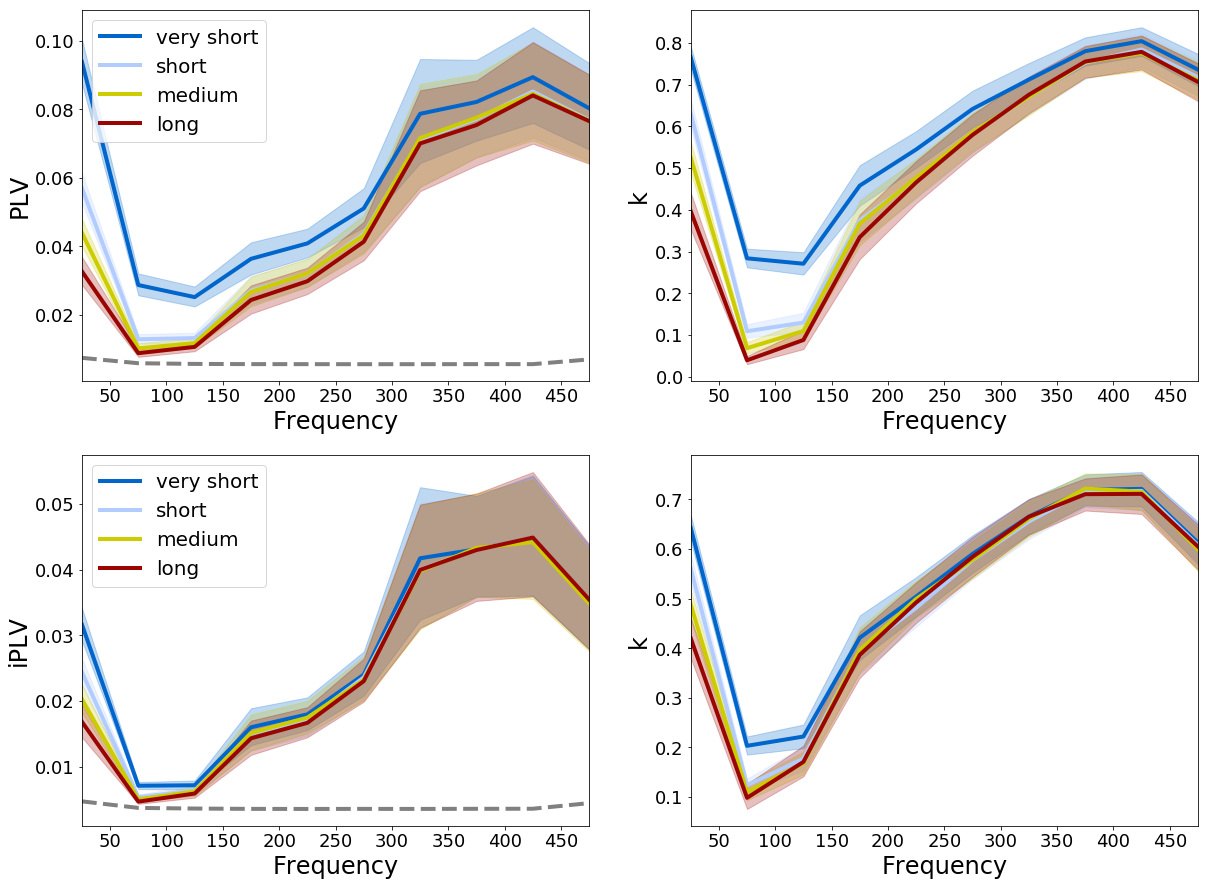

In [13]:
fig, axes = plt.subplots(figsize=(20,15), ncols=2, nrows=2)

for bin_idx, name, color in zip([0,1,2,3], ['very short', 'short', 'medium', 'long'], colors):
    axes[0,0].plot(frequencies, plv_bootstrapped[:,bin_idx].mean(axis=0), color=color, label=name, lw=4)
    axes[0,0].fill_between(frequencies, plv_25[bin_idx], plv_97[bin_idx], color=color, alpha=0.25)
    
    axes[0,1].plot(frequencies, plv_k_bootstrapped[:,bin_idx].mean(axis=0), color=color, label=name, lw=4)
    axes[0,1].fill_between(frequencies, plv_k_25[bin_idx], plv_k_97[bin_idx], color=color, alpha=0.25)
    
axes[0,0].plot(frequencies, surr_plv_lvl, ls='--', color='gray', lw=4)
    
for ax, label in zip(axes[0], ['PLV', 'k']):
    ax.set_ylabel(label, fontsize=24)
    ax.set_xlabel('Frequency', fontsize=24)
    ax.tick_params(labelsize=18)
    
axes[0,0].legend(fontsize=20)

for bin_idx, name, color in zip([0,1,2,3], ['very short', 'short', 'medium', 'long'], colors):
    axes[1,0].plot(frequencies, iplv_bootstrapped[:,bin_idx].mean(axis=0), color=color, label=name, lw=4)
    axes[1,0].fill_between(frequencies, iplv_25[bin_idx], iplv_97[bin_idx], color=color, alpha=0.25)
    
    axes[1,1].plot(frequencies, iplv_k_bootstrapped[:,bin_idx].mean(axis=0), color=color, label=name, lw=4)
    axes[1,1].fill_between(frequencies, iplv_k_25[bin_idx], iplv_k_97[bin_idx], color=color, alpha=0.25)
    
axes[1,0].plot(frequencies, surr_iplv_lvl, ls='--', color='gray', lw=4)
axes[1,0].legend(fontsize=20)
for ax, label in zip(axes[1], ['iPLV', 'k']):
    ax.set_ylabel(label, fontsize=24)
    ax.set_xlabel('Frequency', fontsize=24)
    ax.tick_params(labelsize=18)

for ax in axes.flatten():
    ax.set_xlim([frequencies[0], frequencies[~0]])
    
fig.savefig('fig_Sx_fir_spectrum_with_outliers.svg', dpi=300)

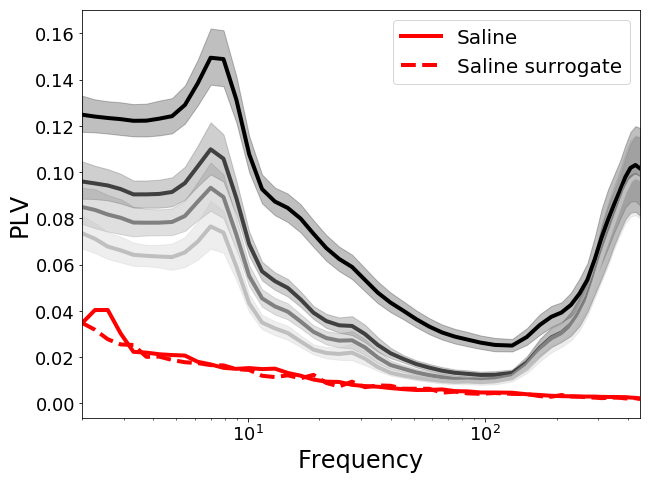

In [12]:
fig, ax = plt.subplots(figsize=(10,7.5))

for bin_idx, name, color in zip([0, 1,2,3], ['very short', 'short', 'medium', 'long'], colors):
    color=(((bin_idx)/4),)*3
    ax.semilogx(frequencies, plv_bootstrapped[:,bin_idx].mean(axis=0), color=color, lw=4)
    ax.fill_between(frequencies, plv_25[bin_idx], plv_97[bin_idx], color=color, alpha=0.25)
    
ax.semilogx(frequencies, np.abs(saline).mean(axis=(1,2)), color='red', lw=4, label='Saline')
ax.semilogx(frequencies, np.abs(saline_surr).mean(axis=(1,2)), ls='--', color='red', label='Saline surrogate', lw=4)
# axes[0,0].semilogx(frequencies, surr_plv_lvl, ls='--', color='gray', lw=4)
    
ax.set_ylabel('PLV', fontsize=24)
ax.set_xlabel('Frequency', fontsize=24)
ax.tick_params(labelsize=18)
    
ax.legend(fontsize=20)

# for bin_idx, name, color in zip([0,1,2,3], ['negliable', 'short', 'medium', 'long'], colors):
#     color=(((bin_idx)/4),)*3
#     axes[1,0].semilogx(frequencies, iplv_bootstrapped[:,bin_idx].mean(axis=0), color=color, lw=4)
#     axes[1,0].fill_between(frequencies, iplv_25[bin_idx], iplv_97[bin_idx], color=color, alpha=0.25)
    
#     axes[1,1].semilogx(frequencies, iplv_k_bootstrapped[:,bin_idx].mean(axis=0), color=color, lw=4)
#     axes[1,1].fill_between(frequencies, iplv_k_25[bin_idx], iplv_k_97[bin_idx], color=color, alpha=0.25)
    
# # axes[1,0].semilogx(frequencies, surr_iplv_lvl, ls='--', color='gray', lw=4)
# axes[1,0].semilogx(frequencies, np.abs(np.imag(saline)).mean(axis=(1,2)), color='red', lw=4)
# axes[1,0].semilogx(frequencies, np.abs(np.imag(saline_surr)).mean(axis=(1,2)), ls='--', color='red', lw=4)

# ax.set_ylabel(label, fontsize=24)
# ax.set_xlabel('Frequency', fontsize=24)
# ax.tick_params(labelsize=18)

ax.set_xlim([frequencies[0], frequencies[~0]])
    
fig.savefig('fig_2_saline.pdf')

In [13]:
# fig, axes = plt.subplots(figsize=(20,7.5), ncols=2)

# for bin_idx, name, color in zip([0,1,2,3], ['negliable', 'short', 'medium', 'long'], colors):
#     axes[0].semilogx(frequencies, iplv_bootstrapped[:,bin_idx].mean(axis=0), color=color, label=name, lw=4)
#     axes[0].fill_between(frequencies, iplv_25[bin_idx], iplv_97[bin_idx], color=color, alpha=0.25)
    
#     axes[1].semilogx(frequencies, iplv_k_bootstrapped[:,bin_idx].mean(axis=0), color=color, label=name, lw=4)
#     axes[1].fill_between(frequencies, iplv_k_25[bin_idx], iplv_k_97[bin_idx], color=color, alpha=0.25)
    
# axes[0].semilogx(frequencies, surr_iplv_lvl, ls='--', color='gray', lw=4)

# for ax, label in zip(axes, ['iPLV', 'k']):
#     ax.set_ylabel(label, fontsize=24)
#     ax.set_xlabel('Frequency', fontsize=24)
#     ax.tick_params(labelsize=18)
    
# axes[0].legend(fontsize=20)

In [14]:
clusters_by_size = cluster_data.groupby('subject_cluster').size().sort_values(ascending=False).index.values
cluster_to_color = {1: 'green', 2:'red', 3:'cyan', 4:'magenta', 5:'orange'}

In [15]:
# fig, axes = plt.subplots(figsize=(12,15), ncols=2, nrows=3)

# for key, ax in zip(clusters_by_size, axes.flatten()):
#     color = cluster_to_color[key]
#     key_spectrum = np.array(spectrum_by_cluster[key])
#     avg_spectrum = key_spectrum.mean(axis=0)
    
#     ax.semilogx(frequencies, avg_spectrum , lw=4, color=color)
#     ax.semilogx(frequencies, key_spectrum.T, color=color, alpha=0.25)
    
#     ax.set_xlabel('Frequency', fontsize=24)
#     ax.set_ylabel('PLV', fontsize=24)
#     ax.tick_params(labelsize=20)
    
# axes[2,1].axis('off')
    
# fig.tight_layout()

# fig.savefig('fig_clusters.pdf')

In [16]:
surrogate_coeffs = list()

for freq_idx in tqdm.tnrange(plv_spectrum.shape[2]):
    surrogate_coeffs.append(estimate_surrogate(plv_spectrum[:,1:,freq_idx].T, bins_values=[1,2,3], N_rounds=1000))

surrogate_coeffs = np.array(surrogate_coeffs)

In [17]:
data_coeffs = list()
orig_coeffs = list()

for freq_idx in tqdm.tnrange(plv_spectrum.shape[2]):
    data_coeffs.append(estimate_bootstrapping(plv_spectrum[:,1:,freq_idx].T, bins_values=[1,2,3]))
    orig_coeffs.append(estimate_single_coeff(plv_spectrum[:,1:,freq_idx].T, bins_values=[1,2,3]))
    
data_coeffs = np.array(data_coeffs)
orig_coeffs = np.array(orig_coeffs)

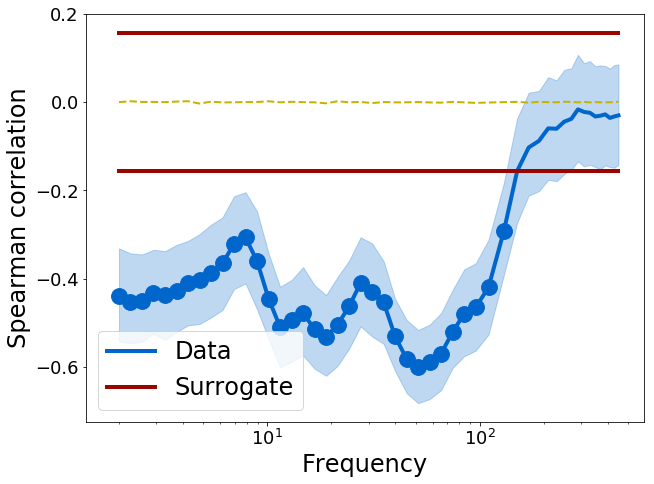

In [22]:
# plt.figure(figsize=(10,7.5))
fig, ax = plt.subplots(figsize=(10, 7.5))

data_25, data_75 = np.percentile(data_coeffs, (5, 95), axis=1)
surr_25, surr_75 = surrogate_coeffs.min(axis=1), surrogate_coeffs.max(axis=1)

surr_level = np.percentile(surrogate_coeffs.min(axis=0), 5)
surr_high = np.percentile(surrogate_coeffs.max(axis=0), 95)

# significance = (data_coeffs >= surr_level).mean(axis=1) + 1/1000

pvals = ((data_coeffs >= surr_level).sum(axis=1) + 1)/(data_coeffs.shape[1] + 1)
h = pvals <= 0.05
h_corrected, pv_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')

ax.semilogx(frequencies, data_coeffs.mean(axis=1), color=ripples_blue, lw=4, label='Data')
ax.fill_between(frequencies, data_25, data_75, color=ripples_blue, alpha=0.25)

ax.plot([frequencies[0], frequencies[~0]], [surr_level, surr_level], lw=4, color=ripples_red, label='Surrogate')
ax.plot([frequencies[0], frequencies[~0]], [surr_high, surr_high], lw=4, color=ripples_red)
ax.plot(frequencies, surrogate_coeffs.mean(axis=1), lw=2, color=ripples_orange, ls='--')
# plt.plot(frequencies, surrogate_coeffs.mean(axis=1), color='red', lw=4, label='Surrogate')
# plt.fill_between(frequencies, surr_25, surr_75, color='red', alpha=0.25)

plt.scatter(frequencies[h], data_coeffs.mean(axis=1)[h], s=250, color=ripples_blue)
# plt.scatter(frequencies[h_corrected], data_coeffs.mean(axis=1)[h_corrected], s=250, color=ripples_blue)

ax.legend(fontsize=24)
ax.set_xlabel('Frequency', fontsize=24)
ax.set_ylabel('Spearman correlation', fontsize=24)
ax.tick_params(labelsize=18)
fig.savefig('fig_2_correlation.pdf')

In [23]:
pvals_df = pd.DataFrame({'frequency': frequencies, 'p-value': pvals, 'p-value_corrected':pv_corrected})
pvals_df.to_csv('figure_2_distance_pvals.csv', index=False)

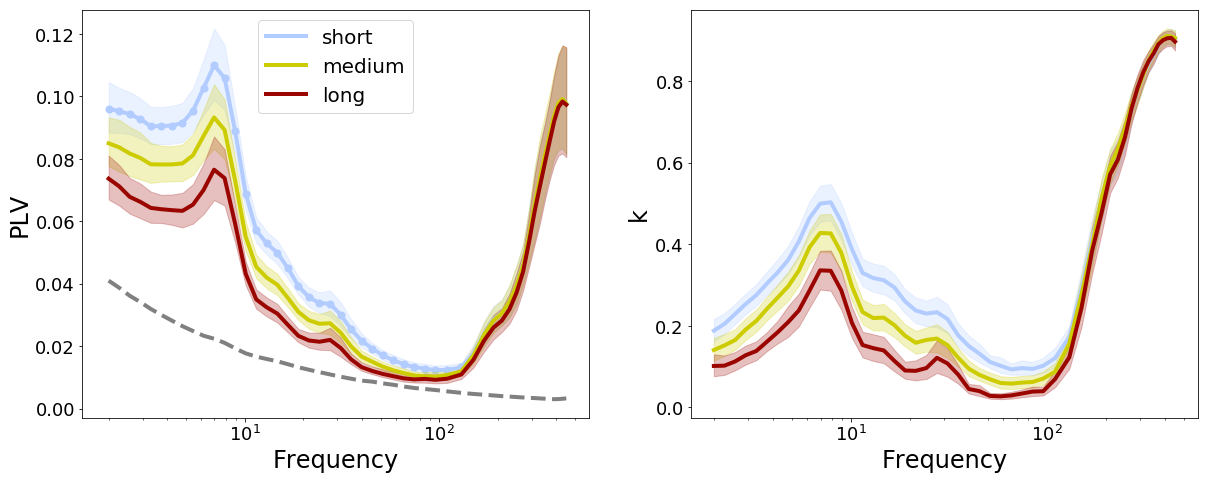

In [20]:
fig, axes = plt.subplots(figsize=(20,7.5), ncols=2)

for bin_idx, name, color in zip([1,2,3], ['short', 'medium', 'long'], colors[1:]):
    axes[0].semilogx(frequencies, plv_bootstrapped[:,bin_idx].mean(axis=0), color=color, label=name, lw=4)
    axes[0].fill_between(frequencies, plv_25[bin_idx], plv_97[bin_idx], color=color, alpha=0.25)
    
    axes[1].semilogx(frequencies, plv_k_bootstrapped[:,bin_idx].mean(axis=0), color=color, label=name, lw=4)
    axes[1].fill_between(frequencies, plv_k_25[bin_idx], plv_k_97[bin_idx], color=color, alpha=0.25)
    
    if bin_idx == 1:
        axes[0].scatter(frequencies[h], plv_bootstrapped[:, bin_idx].mean(axis=0)[h], s=50, color=color)
    
axes[0].semilogx(frequencies, surr_plv_lvl, ls='--', color='gray', lw=4)
    
for ax, label in zip(axes, ['PLV', 'k']):
    ax.set_ylabel(label, fontsize=24)
    ax.set_xlabel('Frequency', fontsize=24)
    ax.tick_params(labelsize=18)
    
axes[0].legend(fontsize=20)

fig.savefig('fig_2_PLV.pdf')

In [21]:
subject_to_cluster = pd.read_csv('Subject_agg_cluster_labels.csv').set_index('subject_number')

In [22]:
# cohort_1 = [31 ,56 ,63 ,26 ,47 ,22 ,66 ,45 ,33 ,50 ,14 ,43 ,25 ,59 ,41 ,53 ,40 ,20 ,49 ,61 ,24 ,17 ,3 ,1]
# cohort_2 = [54 ,27 ,7 ,32 ,23 ,16 ,13 ,55 ,35 ,68 ,19 ,10 ,9 ,39 ,6 ,12 ,62 ,5 ,30 ,8 ,11 ,60 ,44 ,65 ,34]
cohort_1 = [25, 54, 16, 33, 39, 52, 42, 29,  5, 48, 32, 40, 14, 46, 66, 47,
          4, 64, 19, 20, 27, 58, 13, 60, 10, 30, 31,  3, 61,  9, 22]
cohort_2 =  [37, 67, 63, 49, 28, 21, 41, 62,  6,  2, 53,  7, 38, 34,  8, 43,
         55, 45, 23, 18, 59, 11,  0, 50, 44, 26, 24, 65,  1, 15, 12, 57]

cohort_2_mask = np.in1d(subject_numbers, cohort_2)

cohort_1 = [s for s in cohort_1 if subject_to_cluster.loc[s+1]['subject_cluster'] != 4]
cohort_2 = [s for s in cohort_2 if subject_to_cluster.loc[s+1]['subject_cluster'] != 4]

cohort_1_mask = np.in1d(subject_numbers, cohort_1)
cohort_2_mask = np.in1d(subject_numbers, cohort_2)

cohort_1_plv = estimate_mean_with_bootstrap(plv_spectrum[cohort_1_mask], N_rounds=10000)
cohort_2_plv = estimate_mean_with_bootstrap(plv_spectrum[cohort_2_mask], N_rounds=10000)
cohort_1_iplv = estimate_mean_with_bootstrap(iplv_spectrum[cohort_1_mask], N_rounds=10000)
cohort_2_iplv = estimate_mean_with_bootstrap(iplv_spectrum[cohort_2_mask], N_rounds=10000)

c1_plv_5, c1_plv_95 = np.percentile(cohort_1_plv, (5, 95), axis=0)
c1_iplv_5, c1_iplv_95 = np.percentile(cohort_1_iplv, (5, 95), axis=0)
c2_plv_5, c2_plv_95 = np.percentile(cohort_2_plv, (5, 95), axis=0)
c2_iplv_5, c2_iplv_95 = np.percentile(cohort_2_iplv, (5, 95), axis=0)

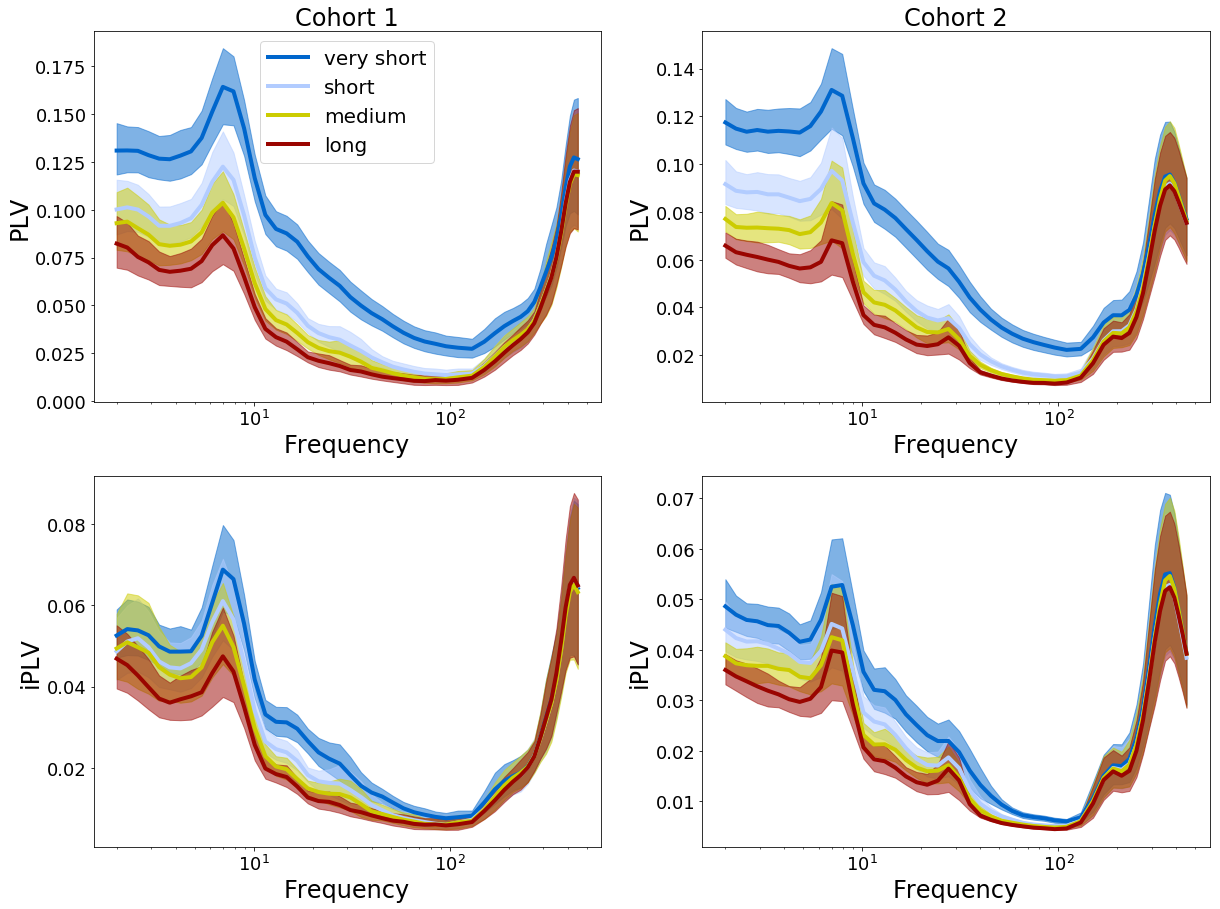

In [23]:
fig, axes = plt.subplots(figsize=(20,15), ncols=2, nrows=2)

for bin_idx, name, color in zip([0, 1,2,3], ['very short', 'short', 'medium', 'long'], colors):    
    axes[0,0].semilogx(frequencies, cohort_1_plv[:,bin_idx].mean(axis=0), color=color, label=name, lw=4)
    axes[0,0].fill_between(frequencies, c1_plv_5[bin_idx], c1_plv_95[bin_idx], color=color, alpha=0.5)
    
    axes[0,1].semilogx(frequencies, cohort_2_plv[:,bin_idx].mean(axis=0), color=color, lw=4)
    axes[0,1].fill_between(frequencies, c2_plv_5[bin_idx], c2_plv_95[bin_idx], color=color, alpha=0.5)
    
    axes[1,0].semilogx(frequencies, cohort_1_iplv[:,bin_idx].mean(axis=0), color=color, lw=4)
    axes[1,0].fill_between(frequencies, c1_iplv_5[bin_idx], c1_iplv_95[bin_idx], color=color, alpha=0.5)
    
    axes[1,1].semilogx(frequencies, cohort_2_iplv[:,bin_idx].mean(axis=0), color=color, lw=4)
    axes[1,1].fill_between(frequencies, c2_iplv_5[bin_idx], c2_iplv_95[bin_idx], color=color, alpha=0.5)
    
# axes[0,0].semilogx(frequencies, surr_plv_lvl, ls='--', color='gray', lw=4)
# axes[0,1].semilogx(frequencies, surr_plv_lvl, ls='--', color='gray', lw=4)
    
for ax in axes.flatten():
    ax.set_xlabel('Frequency', fontsize=24)
    ax.tick_params(labelsize=18)
    
axes[0,0].legend(fontsize=20)
axes[0,0].set_title('Cohort 1', fontsize=24)
axes[0,1].set_title('Cohort 2', fontsize=24)

axes[0,0].set_ylabel('PLV', fontsize=24)
axes[0,1].set_ylabel('PLV', fontsize=24)
axes[1,0].set_ylabel('iPLV', fontsize=24)
axes[1,1].set_ylabel('iPLV', fontsize=24)

fig.savefig('fig_2_PLV_cohorts.svg', dpi=300)

In [24]:
splits = np.load('cov_1.npy')

In [25]:
plv_coefficients = np.zeros((100,4))
iplv_coefficients = np.zeros((100,4))

for sidx, s in enumerate(splits):
    cohort_1 = s[:34]
    cohort_2 = s[34:]

    cohort_2_mask = np.in1d(subject_numbers, cohort_2)

    cohort_1 = [s for s in cohort_1 if s != 35 and subject_to_cluster.loc[s+1]['subject_cluster'] != 4]
    cohort_2 = [s for s in cohort_2 if s != 35 and subject_to_cluster.loc[s+1]['subject_cluster'] != 4]

    cohort_1_mask = np.in1d(subject_numbers, cohort_1)
    cohort_2_mask = np.in1d(subject_numbers, cohort_2)

    cohort_1_plv = plv_spectrum[cohort_1_mask].mean(axis=0)
    cohort_2_plv = plv_spectrum[cohort_2_mask].mean(axis=0)
    cohort_1_iplv = iplv_spectrum[cohort_1_mask].mean(axis=0)
    cohort_2_iplv = iplv_spectrum[cohort_2_mask].mean(axis=0)

    plv_coefficients[sidx] = np.diag(np.corrcoef(cohort_1_plv, cohort_2_plv), 4)
    iplv_coefficients[sidx] = np.diag(np.corrcoef(cohort_1_iplv, cohort_2_iplv), 4)

In [26]:
plv_coefficients_surr = np.zeros((100,4))
iplv_coefficients_surr = np.zeros((100,4))

for sidx, s in enumerate(splits):
    s = s.copy()
    np.random.shuffle(s)
    
    cohort_1 = s[:34]
    cohort_2 = s[34:]

    cohort_2_mask = np.in1d(subject_numbers, cohort_2)

    cohort_1 = [s for s in cohort_1 if s != 35 and subject_to_cluster.loc[s+1]['subject_cluster'] != 4]
    cohort_2 = [s for s in cohort_2 if s != 35 and subject_to_cluster.loc[s+1]['subject_cluster'] != 4]

    cohort_1_mask = np.in1d(subject_numbers, cohort_1)
    cohort_2_mask = np.in1d(subject_numbers, cohort_2)

    cohort_1_plv = plv_spectrum[cohort_1_mask].mean(axis=0)
    cohort_2_plv = plv_spectrum[cohort_2_mask].mean(axis=0)
    cohort_1_iplv = iplv_spectrum[cohort_1_mask].mean(axis=0)
    cohort_2_iplv = iplv_spectrum[cohort_2_mask].mean(axis=0)

    plv_coefficients_surr[sidx] = np.diag(np.corrcoef(cohort_1_plv, cohort_2_plv), 4)
    iplv_coefficients_surr[sidx] = np.diag(np.corrcoef(cohort_1_iplv, cohort_2_iplv), 4)

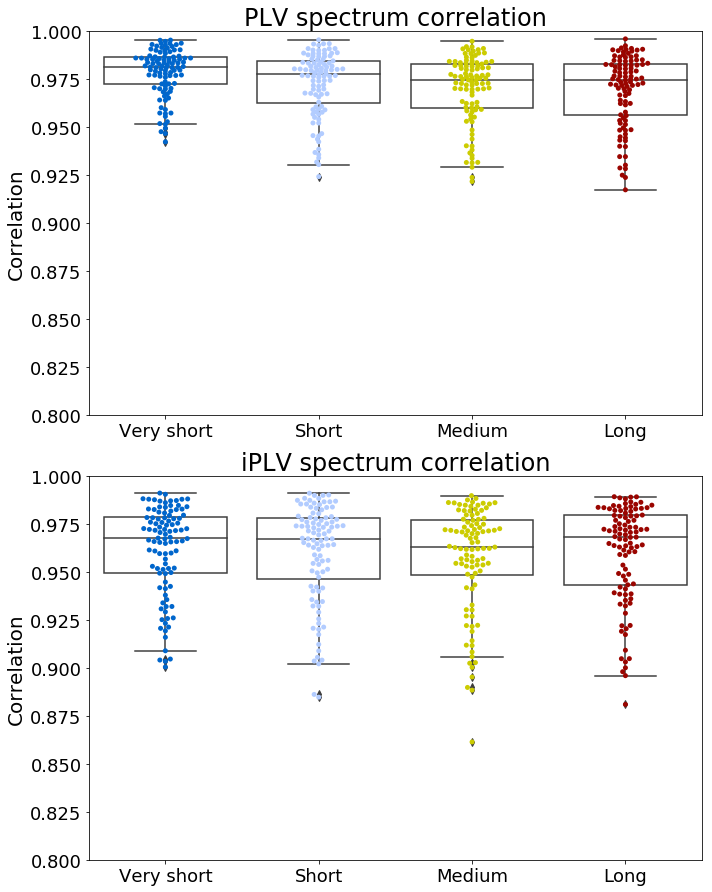

In [29]:
fig, axes = plt.subplots(figsize=(10, 12.5), nrows=2)

# _ = axes[0].boxplot(plv_coefficients)
sns.boxplot(data=plv_coefficients, ax=axes[0])
sns.swarmplot(data=plv_coefficients, ax=axes[0], palette=colors)

sns.boxplot(data=iplv_coefficients, ax=axes[1])
sns.swarmplot(data=iplv_coefficients, ax=axes[1], palette=colors)

for box in axes[0].artists + axes[1].artists:
    box.set_facecolor('white')
    
axes[0].set_title('PLV spectrum correlation', fontsize=24)
axes[1].set_title('iPLV spectrum correlation', fontsize=24)

for ax in axes:
    ax.set_xticklabels(['Very short', 'Short', 'Medium', 'Long'])
    ax.tick_params(labelsize=18)
    ax.set_ylabel('Correlation', fontsize=20)
    
    ax.set_ylim([0.8,1])

fig.tight_layout()
fig.savefig('split_PLV_spectrum_correlation.svg', dpi=300)